# Feature Extraction and Selection
Env: 
- pandas
- numpy
- pyarrow
- tsfresh
- matplotlib

In [2]:
# Exploratory analysis of ECG

import os
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt

wavefront = 'SR' # select from: LVp, RVp, or SR
outpath = '../../../data/features'

inpath = '../../../data/generated'
fname_csv = 'NestedDataS18.csv'
#fname_par = 'NestedDataS18.parquet'
#fname20_csv = 'NestedDataS20.csv'
#fname20_par = 'NestedDataS20.parquet'

/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


### Pre-processing

In [4]:
# read df only with selected columns
usecols = [
    'Point_Number',
    'WaveFront',
    'sheep',
    'signal_data',
    'endocardium_scar',
    'intramural_scar',
    'epicardial_scar',
]
df = pd.read_csv(os.path.join(inpath, fname_csv), usecols=usecols)
# remove nan values
df = df.dropna()

In [5]:
# add column "time" to df which starts at 0 and has the same length as "signal_data" for each Point_Number and WaveFront
df['time'] = df.groupby(['Point_Number', 'WaveFront']).cumcount()

In [6]:
# Generate a column 'scar' that is 1 if either of the scar columns is 1, otherwise 0
df['endocardium_scar'] = df['endocardium_scar'].astype(int)
df['intramural_scar'] = df['intramural_scar'].astype(int)
df['epicardial_scar'] = df['epicardial_scar'].astype(int)
df['scar'] = df[['endocardium_scar', 'intramural_scar', 'epicardial_scar']].max(axis=1)

In [7]:
# select wavefront
df_wf = df[df['WaveFront'] == wavefront]

In [8]:
# generate timeseries and y
timeseries = df_wf[['Point_Number', 'time', 'signal_data']]

# get the scar value for each point
y = df_wf[['Point_Number', 'scar']].drop_duplicates()
# set y to  pandas.Series
y = y.set_index('Point_Number')['scar']


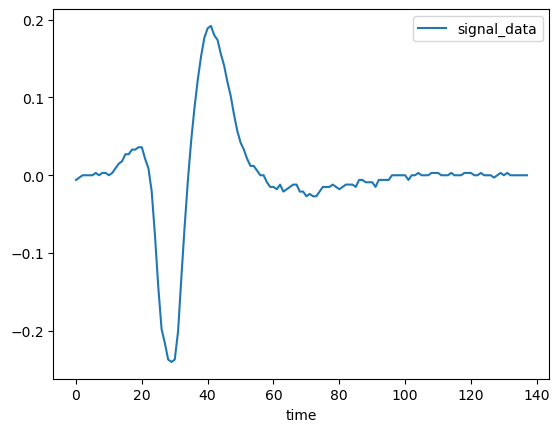

In [9]:
# plot signal data bs time for first point
point_numbers = timeseries['Point_Number'].unique()
timeseries[timeseries['Point_Number'] == point_numbers[0]].plot(x='time', y='signal_data')
plt.show()

### Extract Features

In [10]:
extracted_features = extract_features(timeseries, column_id="Point_Number", column_sort="time")

Feature Extraction:   0%|          | 0/25 [00:00<?, ?it/s]/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt

In [11]:
print('Number of points: ', len(point_numbers))
print('Number of extracted features: ', len(list(extracted_features.columns)))

Number of points:  1329
Number of extracted features:  783


### Select relevant features

In [12]:
impute(extracted_features)
features_relevant = select_features(extracted_features, y)
print(f'Found {len(features_relevant.columns)} relevant features')

/Users/seb/mambaforge/envs/ecg/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['signal_data__fft_coefficient__attr_"real"__coeff_70'
 'signal_data__fft_coefficient__attr_"real"__coeff_71'
 'signal_data__fft_coefficient__attr_"real"__coeff_72'
 'signal_data__fft_coefficient__attr_"real"__coeff_73'
 'signal_data__fft_coefficient__attr_"real"__coeff_74'
 'signal_data__fft_coefficient__attr_"real"__coeff_75'
 'signal_data__fft_coefficient__attr_"real"__coeff_76'
 'signal_data__fft_coefficient__attr_"real"__coeff_77'
 'signal_data__fft_coefficient__attr_"real"__coeff_78'
 'signal_data__fft_coefficient__attr_"real"__coeff_79'
 'signal_data__fft_coefficient__attr_"real"__coeff_80'
 'signal_data__fft_coefficient__attr_"real"__coeff_81'
 'signal_data__fft_coefficient__attr_"real"__coeff_82'
 'signal_data__fft_coefficient__attr_"real"__coeff_83'
 'signal_data__fft_coefficient__attr_"real"__coeff_84'
 'signal_data__fft_coefficient__attr_"rea

Found 123 relevant features


In [13]:
# save to csv
os.makedirs(outpath, exist_ok=True)
fname = 'features_relevant_scar_S18_SR.csv'
features_relevant.to_csv(os.path.join(outpath, fname))

### Generate feature descriptions

In [14]:
# add feature explainer
from tsfresh.feature_extraction import feature_calculators
# get all functions of feature_calculators
all_functions = dir(feature_calculators)
# get description  for each function
descriptions = {}
for function in all_functions:
    if function.startswith('_'):
        continue
    desc = feature_calculators.__dict__[function].__doc__
    if desc:
        try:
            desc = desc.split('\n')[1]
            desc = desc.strip()
        except:
            pass
        descriptions[function] = desc

# get all features that are relevant
relevant_features = features_relevant.columns

# get descriptions for all relevant features
relevant_features_desc = {}
for feature in relevant_features:
    feature = feature.split('__')[1]
    if feature in descriptions:
        relevant_features_desc[feature] = descriptions[feature]
    else:
        relevant_features_desc[feature] = 'No description found'

# save dict to csv
fname_out =os.path.join(outpath, fname.split('.')[0] + '_desc.csv')
relevant_features_desc = pd.DataFrame(relevant_features_desc.items(), columns=['feature', 'description'])
relevant_features_desc.to_csv(fname_out, index=False)